In [1]:
import numpy as np
import pandas as pd
import PIL as pl
import os
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn


from PIL import Image
from matplotlib import cm
import math

from torch import *
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

from PIL import Image
from torch.autograd import Variable


In [2]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Grayscale(),transforms.ToTensor() ,transforms.Normalize((0.5,), (0.5,))])

In [3]:
class GimageLoad(torch.utils.data.Dataset):
    def __init__(self,dataFile,rootdir,transform=None):
        self.imageName = pd.read_csv(os.path.join(rootdir,dataFile),usecols=['FileNames'])
        self.label =  pd.read_csv(os.path.join(rootdir,dataFile),usecols=['M/L'])
        self.root_dir = rootdir
        self.transform = transform
    def __len__(self):
        return len(self.imageName)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imageName.iloc[idx, 0])
        image = Image.open(img_name)
        
        image = self.transform(image)
        labels = self.label.iloc[idx, 0]

        return image,labels

In [4]:
dest_dir =  "C:/FILES/Astrohack/128_test5K/"
Base_dir =f'C:/FILES/Astrohack/128pix_10K/'
root_dir = f'C:/FILES/Astrohack/128pix'

In [10]:
smimage_load_train = GimageLoad(os.path.join(Base_dir,"SMASS_info.csv"), Base_dir,transform)

simageTrainLoader = torch.utils.data.DataLoader(smimage_load_train,batch_size=16,shuffle=True)

In [11]:
smimage_load_test = GimageLoad(os.path.join(dest_dir,"128_test5k.csv"), dest_dir,transform)

simageTestLoader = torch.utils.data.DataLoader(smimage_load_test,batch_size=16,shuffle=True)

In [9]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(0.5))

        self.fc1 = torch.nn.Linear(36992, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5))
        self.fc2 = torch.nn.Linear(625, 1, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN()
model

C:\Users\haek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5)
  )
  (fc1): Linear(in_features=36992, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=36992, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (fc2): Linear(in_features=625, out_features=1, bias=True)
)

In [48]:
im = Image.fromarray(np.uint8(cm.gist_earth(im[0])*255))

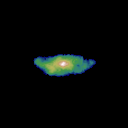

In [54]:
im

In [11]:
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:torch.Tensor, target:torch.Tensor):
        return super().forward(in1.view(-1), target.view(-1))

In [12]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [13]:
import time

def trainNet(model, batch_size, n_epochs, learning_rate,checkpoint_path=os.getcwd()):
    

    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    min_val_loss = np.Inf
    epochs_no_improve = 0
    factor = 3 
    end_lr=1e-3
    

    train_loader = simageTrainLoader
    n_batches = len(train_loader)

    loss = L1LossFlat()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    training_start_time = time.time()

    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            

            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss_size = loss(outputs, labels.float())
            loss_size.backward()
        

            
            optimizer.step()

            running_loss += loss_size.data
            total_train_loss += loss_size.data
            

            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))

                running_loss = 0.0
                start_time = time.time()

        total_val_loss = 0
        for inputs, labels in simageTestLoader:
            

            inputs, labels = Variable(inputs), Variable(labels)
            

            val_outputs = model(inputs)
            val_loss_size = loss(val_outputs, labels.float())

            total_val_loss += val_loss_size.data
    
        val_loss = total_val_loss / len(simageTestLoader)
        print(val_loss)
        if val_loss < min_val_loss:

                torch.save(model, "checkpoint_path")
                epochs_no_improve = 0
                min_val_loss = val_loss
  
        else:
          epochs_no_improve += 1
          
          if epochs_no_improve == n_epochs:
            print('Early stopping!')

            
            model = torch.load(checkpoint_path)


        print("Validation loss = {:.2f}".format(total_val_loss / len(simageTestLoader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    return model

In [22]:
modelcheck_dir =  'C:/FILES/Astrohack/128_test5K/'

In [25]:
simage_cnn = CNN()
simage_cnn1 = trainNet(simage_cnn, batch_size=32, n_epochs=10, learning_rate=0.001,checkpoint_path=modelcheck_dir)

C:\Users\haek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


===== HYPERPARAMETERS =====
batch_size= 32
epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 4.76 took: 122.12s
Epoch 1, 20% 	 train_loss: 0.66 took: 125.28s
Epoch 1, 30% 	 train_loss: 0.56 took: 127.64s
Epoch 1, 40% 	 train_loss: 0.51 took: 125.16s
Epoch 1, 50% 	 train_loss: 0.52 took: 127.22s
Epoch 1, 60% 	 train_loss: 0.48 took: 135.99s
Epoch 1, 70% 	 train_loss: 0.47 took: 131.21s
Epoch 1, 80% 	 train_loss: 0.48 took: 124.40s
Epoch 1, 90% 	 train_loss: 0.49 took: 121.93s
tensor(0.4300)


C:\Users\haek\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation loss = 0.43
Epoch 2, 10% 	 train_loss: 0.46 took: 121.77s
Epoch 2, 20% 	 train_loss: 0.47 took: 128.96s
Epoch 2, 30% 	 train_loss: 0.45 took: 135.30s
Epoch 2, 40% 	 train_loss: 0.46 took: 134.70s
Epoch 2, 50% 	 train_loss: 0.44 took: 141.17s
Epoch 2, 60% 	 train_loss: 0.44 took: 145.09s
Epoch 2, 70% 	 train_loss: 0.47 took: 146.95s
Epoch 2, 80% 	 train_loss: 0.44 took: 143.33s
Epoch 2, 90% 	 train_loss: 0.47 took: 158.36s
tensor(0.4229)
Validation loss = 0.42
Epoch 3, 10% 	 train_loss: 0.42 took: 152.05s
Epoch 3, 20% 	 train_loss: 0.46 took: 149.94s
Epoch 3, 30% 	 train_loss: 0.42 took: 152.27s
Epoch 3, 40% 	 train_loss: 0.46 took: 146.14s
Epoch 3, 50% 	 train_loss: 0.45 took: 147.65s
Epoch 3, 60% 	 train_loss: 0.47 took: 152.07s
Epoch 3, 70% 	 train_loss: 0.44 took: 153.75s
Epoch 3, 80% 	 train_loss: 0.41 took: 148.75s
Epoch 3, 90% 	 train_loss: 0.41 took: 150.26s
tensor(0.4204)
Validation loss = 0.42
Epoch 4, 10% 	 train_loss: 0.41 took: 161.18s
Epoch 4, 20% 	 train_loss: 

In [15]:
smimage_load_test_pred = GimageLoad(os.path.join(dest_dir,"128_test1k.csv"), dest_dir,transform)

simageTestLoader_test = torch.utils.data.DataLoader(smimage_load_test_pred,batch_size=1,shuffle=False)

In [16]:
simage_cnn1.eval()
val_pred_y = []
val_true_y = []
simage_cnn1.eval()
for i,data in enumerate(simageTestLoader_test):
    
            inputs,label = data
            inputs = Variable(inputs.float())
            #Forward pass
            val_outputs = simage_cnn1(inputs)
            val_pred_y.append(val_outputs)
            val_true_y.append(label) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [73]:
val_pred_y1 = [ float(i.detach()[0][0].numpy()) for i in val_pred_y]

val_true_y1 = [ float(i.detach()[0].numpy()) for i in val_true_y]

In [70]:
len(val_true_y1),len(val_pred_y1)

(1000, 1000)

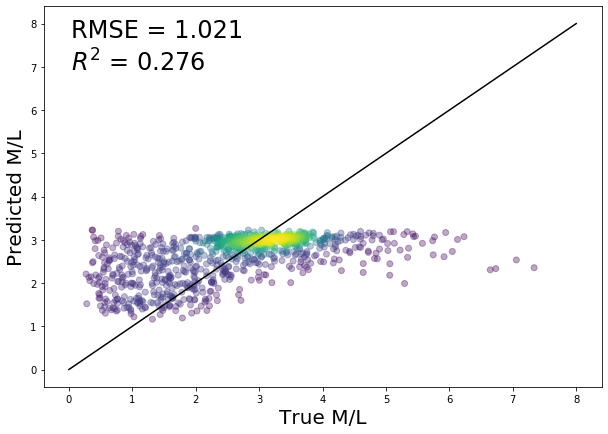

In [72]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = np.array(val_true_y1)
    y_pred = np.array(val_pred_y1)
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()